In [ ]:
#Connect your google drive to google colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Import relevant files from google drive to the runtime
from google.colab import files
files.upload()

In [ ]:
#Importing all the relevant libraries 
from google.colab import files
!pip3 install utils
!pip3 install transforms
!pip3 install sgmllib3k
import pycocotools
import torch
import os
import numpy as np
import torchvision
from torchvision.transforms import Lambda
import matplotlib.pyplot as plt
import cv2
from xml.dom.minidom import parse
import torchvision
import utils
import transforms as T
from trashengine import train_one_epoch, evaluate, validate_one_epoch
from trashdataset import DualClassTrashDataset as trashDataset
from get_prediction import get_label, getprediction
import pandas as pd
from PIL import Image

In [ ]:
# during training, randomly flip the training images and groundtruth for data augmentation 50% chance of flipping horizontally
def get_transform(train):
    transformsList = []
# converts the image, a PIL image, into a PyTorch Tensor
    transformsList.append(T.ToTensor())
    if train:
        transformsList.append(T.RandomHorizontalFlip(0.5))
        transformsList.append(T.RandomPhotometricDistort()  
    return T.Compose(transformsList)

In [ ]:
#Getting the intersection over union and metrics such as TP, FP, FN, TN
def intersection_over_union(gt_box, pred_box):
inter_box_top_left = [max(gt_box[0], pred_box[0]), max(gt_box[1]+1, pred_box[1])]
inter_box_bottom_right = [min(gt_box[0]+gt_box[2], pred_box[0]+pred_box[2]), min(gt_box[1]+gt_box[3], pred_box[1]+pred_box[3])]

    inter_box_w = inter_box_bottom_right[0] - inter_box_top_left[0]
    inter_box_h = inter_box_bottom_right[1] - inter_box_top_left[1]

    intersection = inter_box_w * inter_box_h
    union = gt_box[2]*gt_box[3] + pred_box[2] * pred_box[3] - intersection
    
    iou = intersection / union

    return iou 

def getprediction(img, raw_image):
  boxes_array = []
  label_array = []
  model.eval()
  image = raw_image
  with torch.no_grad():
      prediction = model([img.to(device)])
      scores = prediction[0]['scores']
      boxes_array = prediction[0]['boxes']
      boxes_array = boxes_array[scores > 0.5]
      label_array = prediction[0]['labels']
      label_array = label_array[scores > 0.5]
      labelname_array = []
 
  
  for index in range(len(boxes_array)):
    xmin = round(int(boxes_array[index, 0]))
    ymin = round(int(boxes_array[index, 1]))
    xmax = round(int(boxes_array[index, 2]))
    ymax = round(int(boxes_array[index, 3]))
    
    score = round(scores[index].item(), 2)
    label = label_array[index]
    label = get_label(label)
    labelname_array.append(label)

    boxtext = str(label) + " " + str(score)
cv2.rectangle(image,(xmin,ymin),(xmax,ymax),(51, 51, 255),thickness=1)
cv2.putText(image,boxtext,(xmin,ymin),cv2.FONT_HERSHEY_DUPLEX,0.5,(255, 0, 0), thickness=1)
    
   
  plt.figure(figsize=(12,12))
  plt.imshow(image)
  plt.axis("off")
  return getprediction

def predict(img):
  model.eval()
  with torch.no_grad():
    prediction = model([img.to(device)])
  return prediction

def calAccuracy(ground_truth, prediction, acc_dict):
  # get the scores for the predictions and use a threshold of 0.8
  scores = prediction[0]['scores']
  pred_boxes_array = prediction[0]['boxes'][scores > 0.8]
  pred_label_array = prediction[0]['labels'][scores > 0.8]

  # get the ground truth labels
  gt_label_array = ground_truth[1]['labels']
  gt_boxes_array = ground_truth[1]['boxes']

   # for each detection in the ground truth
  matches = 0
  for index in range(len(gt_boxes_array)):
    for second_index in range(len(pred_boxes_array)):
  if intersection_over_union(gt_boxes_array[index], pred_boxes_array[second_index]) > 0.75:
        matches += 1 # find the total number of matches and use that to find the total number of mismatches

  no_matches = abs(len(gt_boxes_array) - matches)
  acc_dict["No detections"] += no_matches

  # for each detection in the ground truth
  for index in range(len(gt_boxes_array)):
    # check each detection provided
    for second_index in range(len(pred_boxes_array)):
  if intersection_over_union(gt_boxes_array[index], pred_boxes_array   [second_index]) > 0.75:
        # check the predictions
        # prediction = Plastic, Correct
  if (pred_label_array[second_index] == 1) and (pred_label_array[second_index] == gt_label_array[index]):
          acc_dict["True Positive"] += 1
          
        # prediction = Plastic, Incorrect
  if (pred_label_array[second_index] == 1) and (pred_label_array[second_index] != gt_label_array[index]):
          acc_dict["False Positive"] += 1

        # prediction = Other, Incorrect
  if (pred_label_array[second_index] == 2) and (pred_label_array[second_index] != gt_label_array[index]):
          acc_dict["False Negative"] += 1

        # prediction = Other, Correct
if (pred_label_array[second_index] == 2) and (pred_label_array[second_index] == gt_label_array[index]):
          acc_dict["True Negative"] += 1

  return acc_dict


In [ ]:
# Running on cpu or gpu
import torch
device=torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
# Get the path for the dataset
train_path = '/content/drive/MyDrive/Trashdataset/train'
validation_path = '/content/drive/MyDrive/Trashdataset/val'
test_path = '/content/drive/MyDrive/Trashdataset/test'

In [ ]:
#Create the dataset (full dataset)
from torch import Tensor
import torchvision
train_data =trashDataset(train_path, transforms=get_transform(train=True))
validation_data=trashDataset(validation_path,transforms=get_transform(train=False)) 
test_Dataset=trashDataset(test_path,transforms=get_transform(train=False))

In [ ]:
train_data[0][1]

In [ ]:
test_Dataset[50]

In [ ]:
#defining the data loaders
batch_size_train = 4  
batch_size_test = 4    

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size_train, shuffle=True, collate_fn=utils.collate_fn)

val_loader = torch.utils.data.DataLoader(validation_data,batch_size = batch_size_test,shuffle=True, collate_fn=utils.collate_fn)

val_loader_test = torch.utils.data.DataLoader(test_Dataset, batch_size = batch_size_train,shuffle=False, collate_fn=utils.collate_fn)


In [ ]:
#defining the model
number_of_classes = len(train_data.labelDictionary) + 1
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, progress=True, num_classes=number_of_classes, pretrained_backbone=True, trainable_backbone_layers=3)

In [ ]:
#moving the model to the right device
model.to(device)  
# construct an optimizer using SGD
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0003, momentum=0.9, weight_decay= 0.0005) 
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1, T_mult=2) 
num_of_epochs = 31

In [ ]:
#dictionary to save metrics
metrics_dict = {"Training Loss": [], "Training Accuracy": [], "Training Precision": [], "Training Recall":[], "Validation Loss": [], "Validation Accuracy": [],  "Validation Precision": [],  "Validation Recall":[]}

In [ ]:
# train for 31 epoch, printing every 100 iterations
for epoch in range(num_of_epochs):
    # get the training loss
    logger, training_loss = train_one_epoch(model, optimizer, train_loader ,device, epoch, print_freq=100)
    # append the training loss to the metrics dict
    metrics_dict["Training Loss"].append(training_loss)

    # get the validation loss
    val_logger, validation_loss = validate_one_epoch(model, optimizer, val_loader, device, epoch, print_freq=50)
    metrics_dict["Validation Loss"].append(validation_loss)
    # for each image in the training data
    train_acc_dict = {"True Positive": 0, "False Positive":0, "False Negative":0, "True Negative":0, "No detections": 0} 
    for img_package in train_data:
      # get the image tensor and pass it to the model
      img = img_package[0]
      prediction = predict(img)
      train_acc_dict = calAccuracy(img_package, prediction, train_acc_dict)
    # calculate the training accuracy
    train_denom = (train_acc_dict["True Positive"] + train_acc_dict["True Negative"] + train_acc_dict["False Positive"] + train_acc_dict["False Negative"])
    precision_denom = (train_acc_dict["True Positive"] + train_acc_dict["False Positive"])
    recall_denom = (train_acc_dict["True Positive"] + train_acc_dict["False Negative"])
    if train_denom != 0:
      train_accuracy = (train_acc_dict["True Positive"] + train_acc_dict["True Negative"])/train_denom
      metrics_dict["Training Accuracy"].append(train_accuracy)
      # calculate the training precision
      
    if precision_denom != 0:
      train_precision = (train_acc_dict["True Positive"])/precision_denom
      metrics_dict["Training Precision"].append(train_precision)
      # calculate the training recall
      
    if recall_denom != 0:
      train_recall = (train_acc_dict["True Positive"])/recall_denom
      metrics_dict["Training Recall"].append(train_recall)   
   
        

    # get the validation accuracy
    val_acc_dict = {"True Positive": 0, "False Positive":0, "False Negative":0, "True Negative":0, "No detections": 0}
    for img_package in validation_data:
      # get the image tensor and pass it to the model
      img = img_package[0]
      prediction = predict(img)
      val_acc_dict = calAccuracy(img_package, prediction, val_acc_dict)
    # calculate the Validation accuracy
    denom = (val_acc_dict["True Positive"] + val_acc_dict["True Negative"] + val_acc_dict["False Positive"] + val_acc_dict["False Negative"])
    valprecision_denom = (val_acc_dict["True Positive"] + train_acc_dict["False Positive"])
    valrecall_denom = (val_acc_dict["True Positive"] + val_acc_dict["False Negative"])
    if denom != 0:
      val_accuracy = (val_acc_dict["True Positive"] + val_acc_dict["True Negative"])/denom
      metrics_dict["Validation Accuracy"].append(val_accuracy)
 # calculate the validation precision
    if valprecision_denom != 0:
      val_precision = (val_acc_dict["True Positive"])/valprecision_denom
      metrics_dict["Validation Precision"].append(val_precision) 
    # calculate the validation recall
    if valrecall_denom != 0:
      val_recall = (val_acc_dict["True Positive"])/valrecall_denom
      metrics_dict["Validation Recall"].append(val_recall)
    
    print(metrics_dict)
    print(train_acc_dict)
    print(val_acc_dict)
    
    # update the learning rate
    lr_scheduler.step()
    #print(metrics_dict)
    # evaluate on the validation dataset    
    evaluator = evaluate(model, val_loader, device=device)    
    torch.save(model, '/content/drive/MyDrive/Models_for_presentation/two_class_model_with_sgd_testing_val.pkl')
    print('')
    print('==================================================')
    print('')
print("That's it!")

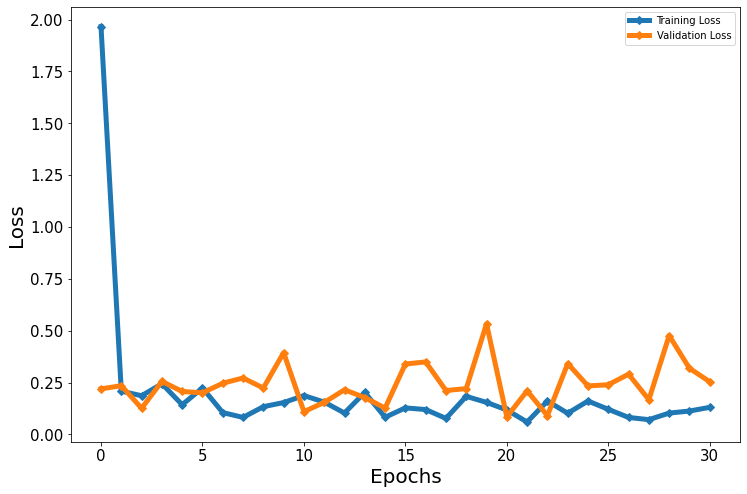

In [ ]:
#Getting the loss graph for training and validation
len(metrics_dict["Training Loss"])
val_loss = []
tran_loss = []
for epoch_losses in metrics_dict["Training Loss"]:
  tran_loss.append(epoch_losses[0])

for epoch_losses in metrics_dict["Validation Loss"]:
  val_loss.append(epoch_losses[0])

plt.figure(figsize=(12,8))
plt.plot(tran_loss, label="Training Loss", linewidth = 5, marker = 'D')
plt.plot(val_loss, label="Validation Loss",linewidth = 5, marker = 'D')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

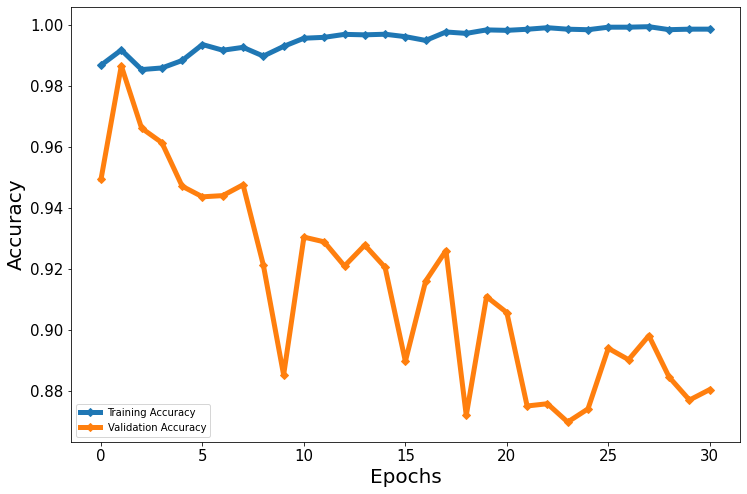

In [ ]:
#Getting the accuracy graph for training and validation
plt.figure(figsize=(12,8))
plt.plot(metrics_dict["Training Accuracy"], label="Training Accuracy", linewidth = 5, marker = 'D')
plt.plot(metrics_dict["Validation Accuracy"], label="Validation Accuracy", linewidth = 5, marker = 'D')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

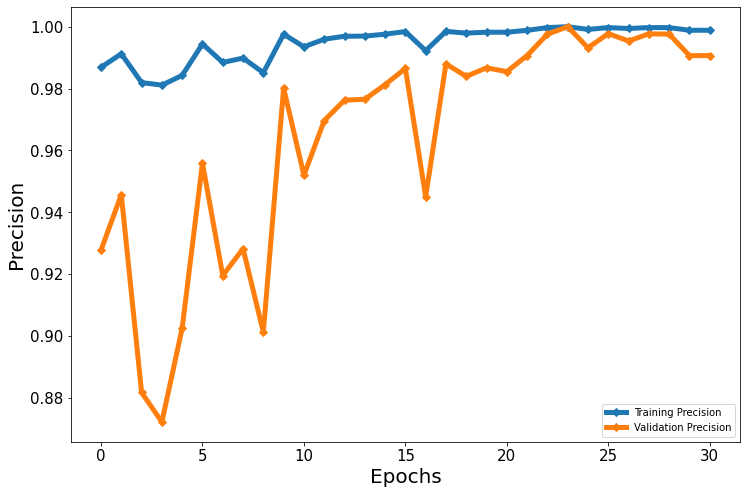

In [ ]:
#Getting the precision graph for training and validation
plt.figure(figsize=(12,8))
plt.plot(metrics_dict["Training Precision"], label="Training Precision", linewidth = 5, marker = 'D')
plt.plot(metrics_dict["Validation Precision"], label="Validation Precision", linewidth = 5, marker = 'D')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

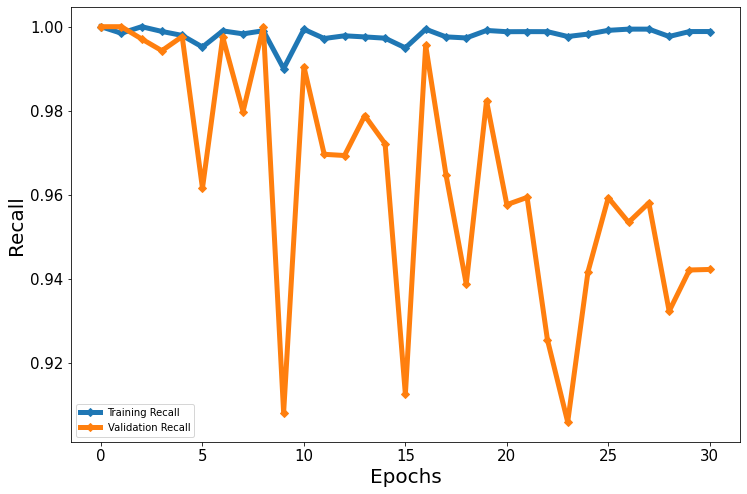

In [ ]:
#Getting the recall graph for training and validation
plt.figure(figsize=(12,8))
plt.plot(metrics_dict["Training Recall"], label="Training Recall", linewidth = 5, marker = 'D')
plt.plot(metrics_dict["Validation Recall"], label="Validation Recall",linewidth = 5, marker = 'D')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

In [ ]:
#Getting the test metrics
test_acc_dict = {"True Positive": 0, "False Positive":0, "False Negative":0, "True Negative":0, "No detections": 0}
for img_package in test_Dataset:
  # Get the image tensor and pass it to the model
  img = img_package[0]
  prediction = predict(img)
  test_acc_dict = calAccuracy(img_package, prediction, test_acc_dict)
# Calculate the test accuracy
denom = (test_acc_dict["True Positive"] + test_acc_dict["True Negative"] + test_acc_dict["False Positive"] + test_acc_dict["False Negative"])
if denom != 0:
  test_accuracy = (test_acc_dict["True Positive"] + test_acc_dict["True Negative"])/denom

 #Calculate the testprecision
test_precision = (test_acc_dict["True Positive"])/ ((test_acc_dict["True Positive"]) + (test_acc_dict["False Positive"]))
# Calculate the testrecall
test_recall = (test_acc_dict["True Positive"])/ ((test_acc_dict["True Positive"]) + (test_acc_dict["False Negative"]))

In [ ]:
print(test_acc_dict)
print(test_accuracy)
print(test_precision)
print(test_recall)

{'True Positive': 303, 'False Positive': 8, 'False Negative': 3, 'True Negative': 278, 'No detections': 1151}
0.981418918918919
0.9742765273311897
0.9901960784313726


In [ ]:
#Getting prediction of images in testdataset (image of index 1123 in this case)
item_index = 1123
img = test_Dataset[item_index][0]
raw_image = np.array(raw_test_data[item_index][0])
random_prediction = getprediction(img, raw_image)